<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter02/model-perf-comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_validate,
)
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from numpy import mean
from collections import Counter
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Synthetic data set prep:

In [8]:
from imblearn.datasets import make_imbalance
from collections import Counter
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd


def make_moons_data(n_samples, noise, random_state=10):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    X = pd.DataFrame(X, columns=["feature 1", "feature 2"])

    def ratio_func(y, multiplier, minority_class):
        target_stats = Counter(y)
        return {minority_class: int(multiplier * target_stats[minority_class])}

    multiplier = 0.1

    X_resampled, y_resampled = make_imbalance(
        X,
        y,
        sampling_strategy=ratio_func,
        random_state=0,
        **{"multiplier": multiplier, "minority_class": 1},
    )
    return X_resampled, y_resampled

Counter({0: 550, 1: 55})


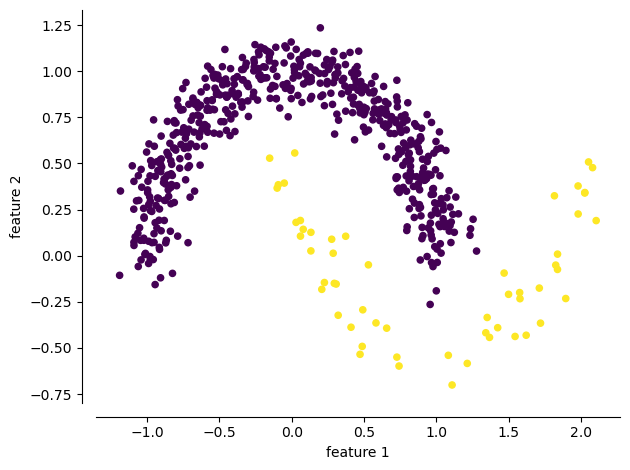

In [9]:
import seaborn as sns

X1, y1 = make_moons_data(n_samples=1100, noise=0.1, random_state=14)
print(Counter(y1))

ax = X1.plot.scatter(
    x="feature 1",
    y="feature 2",
    c=y1,
    colormap="viridis",
    colorbar=False,
)
sns.despine(ax=ax, offset=10)
plt.tight_layout()

In [10]:
synthetic_datasets = []
synthetic_datasets.append(
    {"data": np.array(X1), "target": np.array(y1), "DESCR": "synthetic data"}
)

## Real world data set

In [11]:
# these datasets are baked into imbalanced-learn
dataset_list = ["thyroid_sick"]

In [12]:
# print class imbalance of each dataset
all_datasets = []
all_datasets = synthetic_datasets
le = LabelEncoder()
for dataset in dataset_list:
    data = fetch_datasets()[dataset]
    data["target"] = le.fit_transform(data["target"])
    all_datasets.append(data)

for item in all_datasets:
    print(Counter(item["target"]), item["DESCR"])

RemoteDisconnected: Remote end closed connection without response

In [ ]:
# function to train random forests and evaluate the performance
scaler = MinMaxScaler()


def run_model(classifier, X_train, y_train, oversampler=None):
    model = Pipeline(
        steps=[("minMaxScaling", scaler), ("over", oversampler), ("model", classifier)]
    )
    folds = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=4)
    cv_results = cross_validate(
        model, X_train, y_train, scoring="average_precision", cv=folds, n_jobs=-1
    )
    print(
        "model: ",
        type(classifier).__name__,
        " | cv_results:",
        cv_results["test_score"].mean(),
    )
    return cv_results["test_score"].mean()

In [ ]:
oversampler_map = {
    "Nosampling": None,
    "RandomOverSampler": RandomOverSampler(sampling_strategy="auto", random_state=0),
    "SMOTE": SMOTE(random_state=0),
    "ADASYN": ADASYN(
        sampling_strategy="auto",  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        n_jobs=4,
    ),
    "Borderline-SMOTE": BorderlineSMOTE(
        sampling_strategy="auto",  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind="borderline-1",
        n_jobs=4,
    ),
}

In [ ]:
# now we train several models, with the different OverSampling techniques and
# with cross-validation for each dataset

# save results
pr_mean_dict_lr = {}
pr_mean_dict_rf = {}
pr_mean_dict_xgb = {}


for data in all_datasets:
    pr_mean_dict_lr[data["DESCR"]] = {}
    pr_mean_dict_rf[data["DESCR"]] = {}
    pr_mean_dict_xgb[data["DESCR"]] = {}
    # separate dataset into train and test
    # X_train, X_test, y_train, y_test = train_test_split(
    #     data['data'],
    #     data['target'],
    #     test_size=0.3,
    #     random_state=0,
    #     stratify=data['target']
    # )

    # train model on data without re-sampling
    # with cross-validation
    for oversampler in oversampler_map.keys():
        print(oversampler, " | Dataset description: ", data["DESCR"])
        X, y = data["data"], data["target"]

        # set up the classifier
        lr = LogisticRegression(random_state=0, max_iter=2000)
        aps_mean_lr = run_model(lr, X, y, oversampler_map[oversampler])
        pr_mean_dict_lr[data["DESCR"]][oversampler] = aps_mean_lr

        rf = RandomForestClassifier(
            n_estimators=100, random_state=39, max_depth=3, n_jobs=4
        )
        aps_mean_rf = run_model(rf, X, y, oversampler_map[oversampler])
        pr_mean_dict_rf[data["DESCR"]][oversampler] = aps_mean_rf

        xgb = XGBClassifier()
        aps_mean_xgb = run_model(xgb, X, y, oversampler_map[oversampler])
        pr_mean_dict_xgb[data["DESCR"]][oversampler] = aps_mean_xgb

        print()

Nosampling  | Dataset description:  synthetic data
model:  LogisticRegression  | cv_results: 0.7712053119679325
model:  RandomForestClassifier  | cv_results: 0.8878080751580462
model:  XGBClassifier  | cv_results: 0.9807069387416533

RandomOverSampler  | Dataset description:  synthetic data
model:  LogisticRegression  | cv_results: 0.7712732178674747
model:  RandomForestClassifier  | cv_results: 0.933366035910007
model:  XGBClassifier  | cv_results: 0.981636151819638

SMOTE  | Dataset description:  synthetic data
model:  LogisticRegression  | cv_results: 0.7695915524496135
model:  RandomForestClassifier  | cv_results: 0.911883035401193
model:  XGBClassifier  | cv_results: 0.9813158362620099

ADASYN  | Dataset description:  synthetic data
model:  LogisticRegression  | cv_results: 0.7416527893362935
model:  RandomForestClassifier  | cv_results: 0.9504081847731581
model:  XGBClassifier  | cv_results: 0.9827732239759731

Borderline-SMOTE  | Dataset description:  synthetic data
model:  Logi

In [ ]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

print("\033[1m Logistic Regression, Average Precision")
df_lr = pd.DataFrame(pr_mean_dict_lr)
display(df_lr.round(3))
print("\n")

print("\033[1m Random Forest, Average Precision")
df_rf = pd.DataFrame(pr_mean_dict_rf)
display(df_rf.round(3))
print("\n")


print("\033[1m XGBoost Classifier, Average Precision")
df_xgb = pd.DataFrame(pr_mean_dict_xgb)
display(df_xgb.round(3))

 Logistic Regression, Average Precision


,synthetic data,thyroid_sick
Nosampling,0.771,0.542
RandomOverSampler,0.771,0.616
SMOTE,0.770,0.622
ADASYN,0.742,0.623
Borderline-SMOTE,0.715,0.616




 Random Forest, Average Precision


,synthetic data,thyroid_sick
Nosampling,0.888,0.776
RandomOverSampler,0.933,0.789
SMOTE,0.912,0.778
ADASYN,0.950,0.784
Borderline-SMOTE,0.965,0.786




 XGBoost Classifier, Average Precision


,synthetic data,thyroid_sick
Nosampling,0.981,0.961
RandomOverSampler,0.982,0.967
SMOTE,0.981,0.954
ADASYN,0.983,0.951
Borderline-SMOTE,0.982,0.959


Points to note:
1. Please note that the models used here are not tuned with the best hyperparameters.
Tuning XGBoost parameters would likely make it better than logistic regression here (for example, try with hyperparameters of {'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.2})
2. There is not much difference in the performance of different over-sampling techniques.
3. Barring a few cases, usually, oversampling methods have performed better than no sampling at all
4. As observed above, as the separation between classes increases(separation 2 vs. separation 3), oversampling techniques tend to show bigger performance gains.

----------------------------------------------------------------

Table 1: Logistic Regression average preicision scores on synthetic data
----------------------------------------------------------------

                     lr
Nosampling         0.77
RandomOverSampler  0.77
SMOTE              0.77
ADASYN             0.74
Borderline-SMOTE   0.71
----------------------------------------------------------------

Table 2: Logistic Regression average preicision scores on thyroid_sick
----------------------------------------------------------------

                     lr
Nosampling         0.54
RandomOverSampler  0.62
SMOTE              0.62
ADASYN             0.62
Borderline-SMOTE   0.62
----------------------------------------------------------------

Figure 1: Logistic Regression average preicision scores on synthetic data
----------------------------------------------------------------



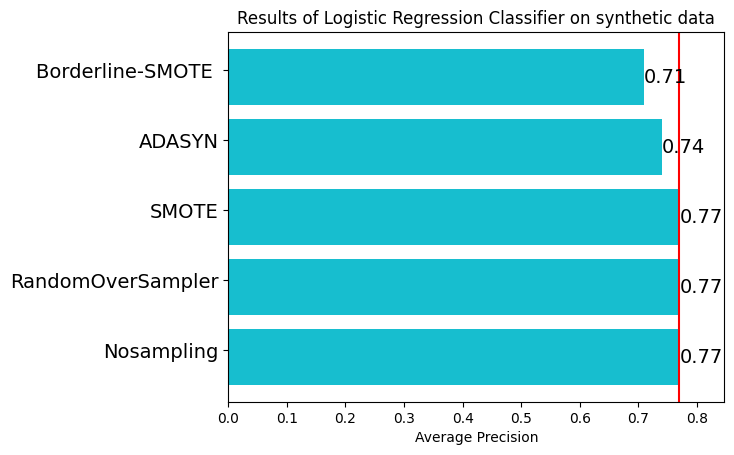

----------------------------------------------------------------

Figure 2: Logistic Regression average preicision scores on thyroid_sick
----------------------------------------------------------------



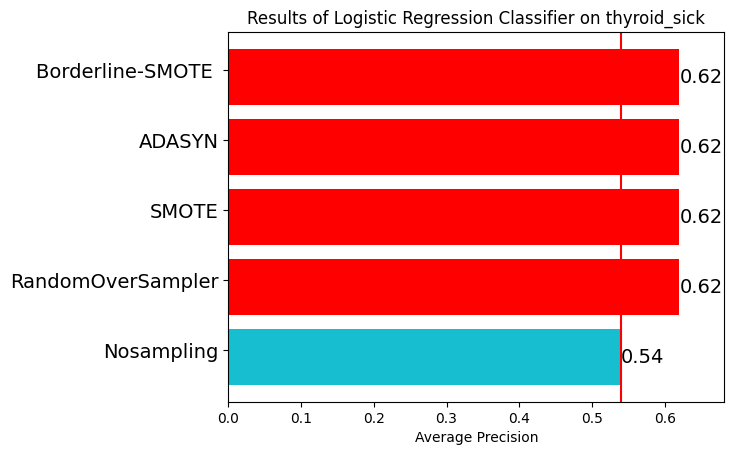

In [ ]:
# Now we plot the performance of the model in the
for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Table "
        + str(i + 1)
        + ": Logistic Regression average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_lr = pd.Series(pr_mean_dict_lr[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_lr], index=["lr"]).T
    print(df)


for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Figure "
        + str(i + 1)
        + ": Logistic Regression average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_lr = pd.Series(pr_mean_dict_lr[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_lr], index=["lr"]).T

    colors = []
    colors.append("#17becf")
    for j in range(1, 5):
        if df["lr"][j] > df["lr"][0]:
            colors.append("r")
        else:
            colors.append("#17becf")

    r = np.arange(5)  # plotting for 5 different overampling techniques
    fig, ax = plt.subplots()
    ax.barh(r, df["lr"], align="center", color=colors)
    ax.set_xlabel("Average Precision")
    plt.axvline(df["lr"][0], color="r")
    plt.yticks(
        [r + 0.1 for r in range(5)],
        ["Nosampling", "RandomOverSampler", "SMOTE", "ADASYN", "Borderline-SMOTE "],
        fontsize=14,
    )
    maximum = df["lr"].max()
    plt.xlim(0, maximum + 0.10 * maximum)
    plt.title(
        "Results of Logistic Regression Classifier on %s" % (all_datasets[i]["DESCR"])
    )
    ax.bar_label(ax.containers[0], fontsize=14)
    plt.show()

----------------------------------------------------------------

Table 1: Random Forest average preicision scores on synthetic data
----------------------------------------------------------------

                     rf
Nosampling         0.89
RandomOverSampler  0.93
SMOTE              0.91
ADASYN             0.95
Borderline-SMOTE   0.96
----------------------------------------------------------------

Table 2: Random Forest average preicision scores on thyroid_sick
----------------------------------------------------------------

                     rf
Nosampling         0.78
RandomOverSampler  0.79
SMOTE              0.78
ADASYN             0.78
Borderline-SMOTE   0.79
----------------------------------------------------------------

Figure 1: Random Forest average preicision scores on synthetic data
----------------------------------------------------------------



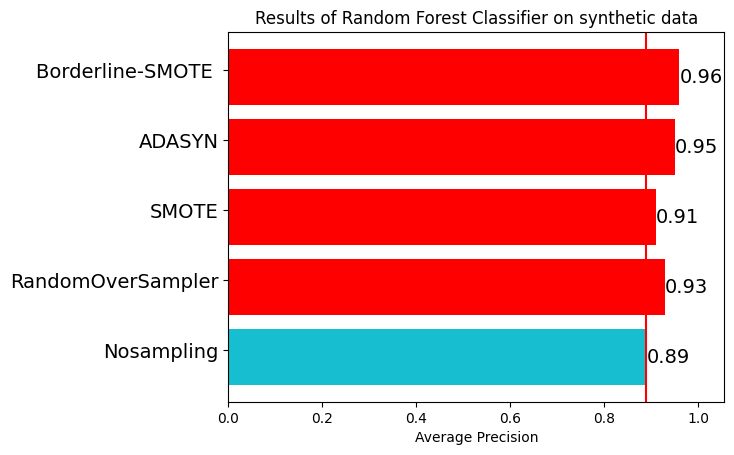

----------------------------------------------------------------

Figure 2: Random Forest average preicision scores on thyroid_sick
----------------------------------------------------------------



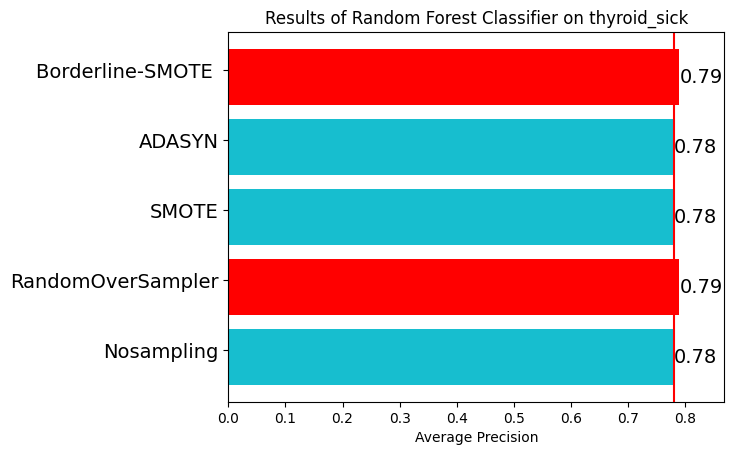

In [ ]:
# Now we plot the performance of the model in the
for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Table "
        + str(i + 1)
        + ": Random Forest average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_rf = pd.Series(pr_mean_dict_rf[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_rf], index=["rf"]).T
    print(df)


for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Figure "
        + str(i + 1)
        + ": Random Forest average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_rf = pd.Series(pr_mean_dict_rf[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_rf], index=["rf"]).T

    colors = []
    colors.append("#17becf")
    for j in range(1, 5):
        if df["rf"][j] > df["rf"][0]:
            colors.append("r")
        else:
            colors.append("#17becf")

    r = np.arange(5)  # plotting for 5 different overampling techniques
    fig, ax = plt.subplots()
    ax.barh(r, df["rf"], align="center", color=colors)
    ax.set_xlabel("Average Precision")
    plt.axvline(df["rf"][0], color="r")
    plt.yticks(
        [r + 0.1 for r in range(5)],
        ["Nosampling", "RandomOverSampler", "SMOTE", "ADASYN", "Borderline-SMOTE "],
        fontsize=14,
    )
    maximum = df["rf"].max()
    plt.xlim(0, maximum + 0.10 * maximum)
    plt.title("Results of Random Forest Classifier on %s" % (all_datasets[i]["DESCR"]))
    ax.bar_label(ax.containers[0], fontsize=14)
    plt.show()

----------------------------------------------------------------

Table 1: XGBoost average preicision scores on synthetic data
----------------------------------------------------------------

                    xgb
Nosampling         0.98
RandomOverSampler  0.98
SMOTE              0.98
ADASYN             0.98
Borderline-SMOTE   0.98
----------------------------------------------------------------

Table 2: XGBoost average preicision scores on thyroid_sick
----------------------------------------------------------------

                    xgb
Nosampling         0.96
RandomOverSampler  0.97
SMOTE              0.95
ADASYN             0.95
Borderline-SMOTE   0.96
----------------------------------------------------------------

Figure 1: XGBoost average preicision scores on synthetic data
----------------------------------------------------------------



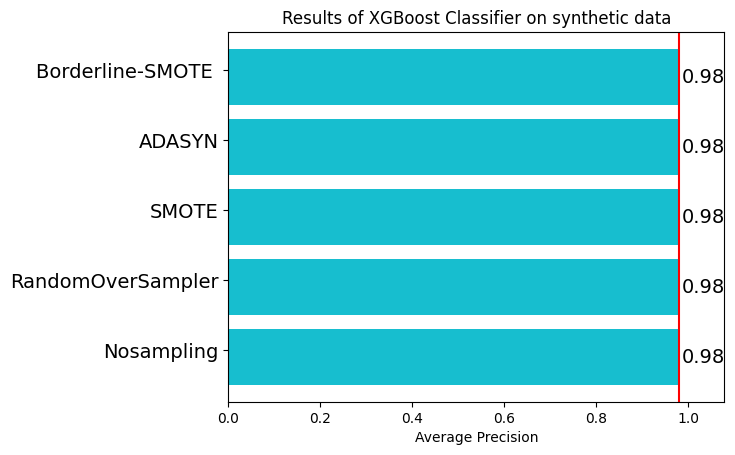

----------------------------------------------------------------

Figure 2: XGBoost average preicision scores on thyroid_sick
----------------------------------------------------------------



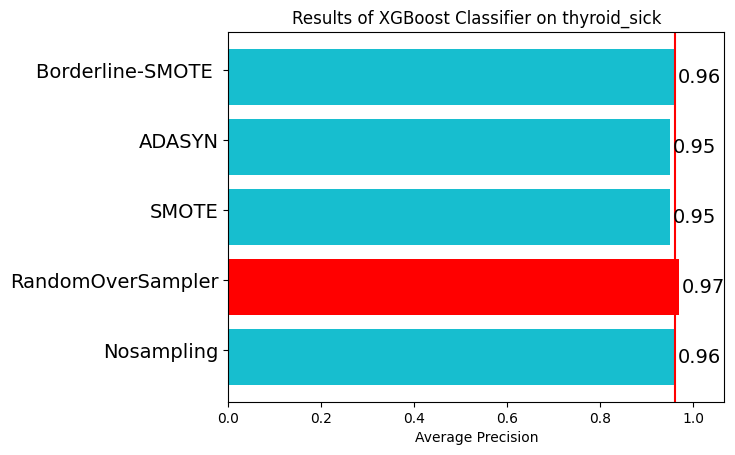

In [ ]:
# Now we plot the performance of the model in the
for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Table "
        + str(i + 1)
        + ": XGBoost average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_xgb = pd.Series(pr_mean_dict_xgb[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_xgb], index=["xgb"]).T
    print(df)


for i, dataset in enumerate(all_datasets):
    print("----------------------------------------------------------------\n")
    print(
        "Figure "
        + str(i + 1)
        + ": XGBoost average preicision scores on "
        + str((all_datasets[i]["DESCR"]))
    )
    print("----------------------------------------------------------------\n")
    pr_mean_s_xgb = pd.Series(pr_mean_dict_xgb[dataset["DESCR"]]).round(2)
    df = pd.DataFrame([pr_mean_s_xgb], index=["xgb"]).T

    colors = []
    colors.append("#17becf")
    for j in range(1, 5):
        if df["xgb"][j] > df["xgb"][0]:
            colors.append("r")
        else:
            colors.append("#17becf")

    r = np.arange(5)  # plotting for 5 different overampling techniques
    fig, ax = plt.subplots()
    ax.barh(r, df["xgb"], align="center", color=colors)
    ax.set_xlabel("Average Precision")
    plt.axvline(df["xgb"][0], color="r")
    plt.yticks(
        [r + 0.1 for r in range(5)],
        ["Nosampling", "RandomOverSampler", "SMOTE", "ADASYN", "Borderline-SMOTE "],
        fontsize=14,
    )
    maximum = df["xgb"].max()
    plt.xlim(0, maximum + 0.10 * maximum)
    plt.title("Results of XGBoost Classifier on %s" % (all_datasets[i]["DESCR"]))
    ax.bar_label(ax.containers[0], fontsize=14, padding=2)
    plt.show()